In [1]:
# import stuff
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn import model_selection

import torch
import torch.utils.data as data
from itertools import product as product

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Function

import librosa

# Any results you write to the current directory are saved as output.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
from tqdm import tqdm_notebook as tqdm
from torch.optim import lr_scheduler

import sklearn.metrics

In [2]:
os.makedirs("log", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [3]:
batch_size = 8
watermark = "resnet34"
model_name = watermark
CONTINUE = False

# define directories
base_dir = "./"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

# save train?
SAVE_DATA = True

wave size:(220500,)
melsp size:(128, 1723)
samping rate:44100


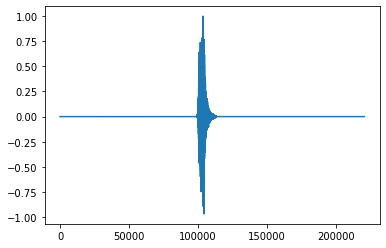

no display


In [4]:
# load a wave data
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path, sr=44100)
    return x,fs

# change wave data to mel-stft
def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_stft = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_stft,n_mels=128)
    return melsp

# display wave in plots
def show_wave(x):
    plt.plot(x)
    plt.show()

# display wave in heatmap
def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs)
    plt.colorbar()
    plt.show()

# example data
x, fs = load_wave_data(audio_dir, meta_data.loc[0,"filename"])
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
try:
    show_melsp(melsp, fs)
except:
    print("no display")

# setup dataloaders

In [5]:
# define directories
base_dir = "./"
esc_dir = os.path.join(base_dir, "ESC-50-master")
meta_file = os.path.join(esc_dir, "meta/esc50.csv")
audio_dir = os.path.join(esc_dir, "audio/")

# load metadata
meta_data = pd.read_csv(meta_file)

In [6]:
# data augmentation: add white noise
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

# data augmentation: shift sound in timeframe
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

# data augmentation: stretch sound
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(x, rate)
    if len(x)>input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

In [7]:
class ESC50Dataset(Dataset):
    def __init__(self, data, label, data_aug=False, _type='train'):
        self.label = label
        self.data_aug = data_aug
        self.data = data
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self,idx):
        label = self.label[idx]
        x, fs = load_wave_data(audio_dir, self.data[idx])
        
        # augumentations in wave domain.
        if self.data_aug:
            r = np.random.rand()
            if r < 0.3:
                x = add_white_noise(x)

            r = np.random.rand()
            if r < 0.3:
                x = shift_sound(x, rate=1+np.random.rand())

            r = np.random.rand()
            if r < 0.3:
                x = stretch_sound(x, rate=0.8+np.random.rand()*0.4)
        
        # convert to melsp
        melsp = calculate_melsp(x)
        
        # normalize
        mean = np.mean(melsp)
        std = np.std(melsp)
        
        melsp -= mean
        melsp /= std
        
        melsp = np.asarray([melsp, melsp, melsp])
        return melsp, label

In [8]:
# get training dataset and target dataset
x = list(meta_data.loc[:,"filename"])
y = list(meta_data.loc[:, "target"])

x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.25, stratify=y, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


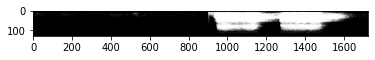

In [9]:
traindataset = ESC50Dataset(x_train, y_train, data_aug=True)
testdataset = ESC50Dataset(x_test, y_test, data_aug=False)
train_loader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,shuffle=True, num_workers=0)

mel, label = traindataset[0]
plt.imshow(mel.transpose([1,2,0]))

# setup model

In [10]:
# backbone
import pretrainedmodels
basemodel = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
# print(basemodel)
basemodel = nn.Sequential(*list(basemodel.children())[:-2])
print(basemodel)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [11]:
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.features = basemodel
        if model_name == "resnet34" or model_name == "resnet18":
            num_ch = 512
        else:
            num_ch = 2048
        self.fc = nn.Conv2d(num_ch, 50, 1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = self.fc(x).squeeze(2).squeeze(2)
        return x

In [12]:
model = mymodel()
input = torch.rand([1,3,128,128])
model(input).size()

torch.Size([1, 50])

# optimizers

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mymodel().to(device)
optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epochs = 100 # original 50

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True, min_lr=1e-3*1e-4, factor=0.33)

# train loop

In [14]:
def train(epoch):
    model.train()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc = 0.0

    t = tqdm(train_loader)
    
    for idx, (inputs,labels) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
     
        # set opt
        optimizer.zero_grad()
        
        # run model
        outputs = model(inputs.float())
            
        loss = criterion(outputs,labels)
        # misc
        running_loss += loss
        running_acc += (outputs.argmax(1)==labels).float().mean()
        acc += (outputs.argmax(1)==labels).float().mean()
        loss.backward()
        optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.4f})(a1={acc/(idx+1):.4f})')
        if idx%8==7:
            rd = np.random.rand()
        
    #scheduler.step()
    losses.append(running_loss/len(train_loader))
    accs.append(running_acc/(len(train_loader)))
    print('train acc : {:.2f}%'.format(running_acc/(len(train_loader))))
    print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('dev acc1 : {:.2f}%'.format(acc/(len(train_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                     'loss': running_loss/len(train_loader), "acc1": acc/(len(train_loader))}
    logs.append(log_epoch)
    df = pd.DataFrame(logs)
    df.to_csv("log/log_output_train_{}.csv".format(watermark))
    

In [15]:
def eval(epoch):
    model.eval()
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    acc = 0.0

    t = tqdm(test_loader)
    
    for idx, (inputs,labels) in enumerate(t):       
        # send to gpu
        inputs = inputs.to(device)
        labels = labels.to(device)
     
        # set opt
        optimizer.zero_grad()
        
        with torch.no_grad():
            # run model
            outputs = model(inputs.float())
            
        loss = criterion(outputs,labels)
        # misc
        running_loss += loss
        running_acc += (outputs.argmax(1)==labels).float().mean()
        acc += (outputs.argmax(1)==labels).float().mean()
        #loss.backward()
        #optimizer.step()
        
        t.set_description(f't (l={running_loss/(idx+1):.4f})(a1={acc/(idx+1):.4f})')
        if idx%8==7:
            rd = np.random.rand()
        
    #scheduler.step()
    losses.append(running_loss/len(test_loader))
    accs.append(running_acc/(len(test_loader)))
    print('eval acc : {:.2f}%'.format(running_acc/(len(test_loader))))
    print('eval loss : {:.4f}'.format(running_loss/len(test_loader)))
    print('dev acc1 : {:.2f}%'.format(acc/(len(test_loader))))
    
    # save logs
    log_epoch = {'epoch': epoch+1, 'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                     'loss': running_loss/len(test_loader), "acc1": acc/(len(test_loader))}
    logs_eval.append(log_epoch)
    df = pd.DataFrame(logs_eval)
    df.to_csv("log/log_output_eval_{}.csv".format(watermark))
    

In [16]:
import gc
logs = []
logs_eval = []
losses = []
accs = []
logs = []
start = 0
epochs = 100

if CONTINUE:
    #start = START
    model.load_state_dict(torch.load("./models/cutonly_se_resnext50_32x4d_cutmix_236_29epochs_saved_weights.pth"))

for epoch in range(start, epochs):
    torch.cuda.empty_cache()
    train(epoch)
    torch.cuda.empty_cache()
    eval(epoch)
    if epoch %10==0:
        torch.save(model.state_dict(), './models/{}_{}epochs_saved_weights.pth'.format(watermark, epoch))
    # GC
    torch.cuda.empty_cache()
    gc.collect()
    

epochs 1/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.30%
train loss : 2.7754
dev acc1 : 0.30%
epochs 1/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.57%
eval loss : 1.5448
dev acc1 : 0.57%
epochs 2/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.61%
train loss : 1.5742
dev acc1 : 0.61%
epochs 2/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.70%
eval loss : 1.0173
dev acc1 : 0.70%
epochs 3/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.74%
train loss : 1.0863
dev acc1 : 0.74%
epochs 3/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.73%
eval loss : 1.0199
dev acc1 : 0.73%
epochs 4/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.81%
train loss : 0.7775
dev acc1 : 0.81%
epochs 4/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6081
dev acc1 : 0.84%
epochs 5/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.87%
train loss : 0.5932
dev acc1 : 0.87%
epochs 5/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6095
dev acc1 : 0.85%
epochs 6/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.88%
train loss : 0.5265
dev acc1 : 0.88%
epochs 6/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5661
dev acc1 : 0.86%
epochs 7/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.91%
train loss : 0.3921
dev acc1 : 0.91%
epochs 7/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6051
dev acc1 : 0.85%
epochs 8/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.92%
train loss : 0.3264
dev acc1 : 0.92%
epochs 8/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.4561
dev acc1 : 0.89%
epochs 9/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.94%
train loss : 0.2720
dev acc1 : 0.94%
epochs 9/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.90%
eval loss : 0.4222
dev acc1 : 0.90%
epochs 10/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.95%
train loss : 0.2457
dev acc1 : 0.95%
epochs 10/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6341
dev acc1 : 0.84%
epochs 11/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.94%
train loss : 0.2568
dev acc1 : 0.94%
epochs 11/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6288
dev acc1 : 0.84%
epochs 12/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.95%
train loss : 0.2166
dev acc1 : 0.95%
epochs 12/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.5481
dev acc1 : 0.85%
epochs 13/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.96%
train loss : 0.1894
dev acc1 : 0.96%
epochs 13/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.7049
dev acc1 : 0.83%
epochs 14/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.96%
train loss : 0.1861
dev acc1 : 0.96%
epochs 14/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.7004
dev acc1 : 0.85%
epochs 15/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.95%
train loss : 0.2032
dev acc1 : 0.95%
epochs 15/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5170
dev acc1 : 0.86%
epochs 16/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.96%
train loss : 0.1704
dev acc1 : 0.96%
epochs 16/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.5474
dev acc1 : 0.87%
epochs 17/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1232
dev acc1 : 0.98%
epochs 17/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6320
dev acc1 : 0.85%
epochs 18/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1268
dev acc1 : 0.97%
epochs 18/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6125
dev acc1 : 0.85%
epochs 19/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.96%
train loss : 0.1626
dev acc1 : 0.96%
epochs 19/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6301
dev acc1 : 0.87%
epochs 20/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1335
dev acc1 : 0.97%
epochs 20/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6209
dev acc1 : 0.86%
epochs 21/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0980
dev acc1 : 0.98%
epochs 21/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6327
dev acc1 : 0.84%
epochs 22/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1254
dev acc1 : 0.97%
epochs 22/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6111
dev acc1 : 0.84%
epochs 23/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1396
dev acc1 : 0.97%
epochs 23/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.7883
dev acc1 : 0.83%
epochs 24/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1283
dev acc1 : 0.97%
epochs 24/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6174
dev acc1 : 0.87%
epochs 25/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1131
dev acc1 : 0.97%
epochs 25/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6290
dev acc1 : 0.87%
epochs 26/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.0940
dev acc1 : 0.97%
epochs 26/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6567
dev acc1 : 0.86%
epochs 27/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0925
dev acc1 : 0.98%
epochs 27/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6871
dev acc1 : 0.84%
epochs 28/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.96%
train loss : 0.1634
dev acc1 : 0.96%
epochs 28/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.5464
dev acc1 : 0.85%
epochs 29/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1003
dev acc1 : 0.97%
epochs 29/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.7741
dev acc1 : 0.84%
epochs 30/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0891
dev acc1 : 0.98%
epochs 30/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6040
dev acc1 : 0.87%
epochs 31/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0821
dev acc1 : 0.98%
epochs 31/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6511
dev acc1 : 0.87%
epochs 32/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0918
dev acc1 : 0.98%
epochs 32/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5796
dev acc1 : 0.88%
epochs 33/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0710
dev acc1 : 0.98%
epochs 33/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5026
dev acc1 : 0.88%
epochs 34/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0962
dev acc1 : 0.98%
epochs 34/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5896
dev acc1 : 0.86%
epochs 35/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1216
dev acc1 : 0.97%
epochs 35/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6966
dev acc1 : 0.84%
epochs 36/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.1113
dev acc1 : 0.98%
epochs 36/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.5234
dev acc1 : 0.89%
epochs 37/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0734
dev acc1 : 0.98%
epochs 37/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5310
dev acc1 : 0.88%
epochs 38/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0774
dev acc1 : 0.99%
epochs 38/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5447
dev acc1 : 0.86%
epochs 39/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0666
dev acc1 : 0.99%
epochs 39/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.5526
dev acc1 : 0.87%
epochs 40/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0851
dev acc1 : 0.98%
epochs 40/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.7210
dev acc1 : 0.86%
epochs 41/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0740
dev acc1 : 0.98%
epochs 41/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.7485
dev acc1 : 0.84%
epochs 42/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1196
dev acc1 : 0.97%
epochs 42/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.5640
dev acc1 : 0.86%
epochs 43/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1135
dev acc1 : 0.97%
epochs 43/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5510
dev acc1 : 0.88%
epochs 44/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0349
dev acc1 : 0.99%
epochs 44/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6557
dev acc1 : 0.86%
epochs 45/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0870
dev acc1 : 0.98%
epochs 45/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.79%
eval loss : 1.0064
dev acc1 : 0.79%
epochs 46/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0765
dev acc1 : 0.98%
epochs 46/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6625
dev acc1 : 0.87%
epochs 47/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0298
dev acc1 : 0.99%
epochs 47/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.6132
dev acc1 : 0.88%
epochs 48/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 1.00%
train loss : 0.0172
dev acc1 : 1.00%
epochs 48/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.5157
dev acc1 : 0.89%
epochs 49/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0473
dev acc1 : 0.99%
epochs 49/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.6834
dev acc1 : 0.83%
epochs 50/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0508
dev acc1 : 0.99%
epochs 50/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5329
dev acc1 : 0.88%
epochs 51/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0922
dev acc1 : 0.98%
epochs 51/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.8249
dev acc1 : 0.84%
epochs 52/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1006
dev acc1 : 0.97%
epochs 52/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.6746
dev acc1 : 0.84%
epochs 53/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0690
dev acc1 : 0.99%
epochs 53/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.6986
dev acc1 : 0.88%
epochs 54/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0322
dev acc1 : 0.99%
epochs 54/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.8043
dev acc1 : 0.85%
epochs 55/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0543
dev acc1 : 0.99%
epochs 55/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.6392
dev acc1 : 0.85%
epochs 56/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0554
dev acc1 : 0.98%
epochs 56/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.80%
eval loss : 0.8546
dev acc1 : 0.80%
epochs 57/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0861
dev acc1 : 0.98%
epochs 57/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.7077
dev acc1 : 0.86%
epochs 58/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0513
dev acc1 : 0.99%
epochs 58/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.7056
dev acc1 : 0.85%
epochs 59/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0428
dev acc1 : 0.99%
epochs 59/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.6416
dev acc1 : 0.88%
epochs 60/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0493
dev acc1 : 0.99%
epochs 60/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.5566
dev acc1 : 0.87%
epochs 61/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0673
dev acc1 : 0.98%
epochs 61/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6638
dev acc1 : 0.86%
epochs 62/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0520
dev acc1 : 0.99%
epochs 62/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5335
dev acc1 : 0.88%
epochs 63/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0373
dev acc1 : 0.99%
epochs 63/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.5585
dev acc1 : 0.89%
epochs 64/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0503
dev acc1 : 0.99%
epochs 64/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.7020
dev acc1 : 0.86%
epochs 65/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.0969
dev acc1 : 0.97%
epochs 65/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.7433
dev acc1 : 0.83%
epochs 66/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.97%
train loss : 0.1010
dev acc1 : 0.97%
epochs 66/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6546
dev acc1 : 0.86%
epochs 67/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0739
dev acc1 : 0.98%
epochs 67/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6505
dev acc1 : 0.86%
epochs 68/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0497
dev acc1 : 0.99%
epochs 68/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.5755
dev acc1 : 0.87%
epochs 69/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0424
dev acc1 : 0.99%
epochs 69/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.5521
dev acc1 : 0.88%
epochs 70/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 1.00%
train loss : 0.0204
dev acc1 : 1.00%
epochs 70/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.88%
eval loss : 0.6400
dev acc1 : 0.88%
epochs 71/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0588
dev acc1 : 0.98%
epochs 71/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.7164
dev acc1 : 0.84%
epochs 72/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0316
dev acc1 : 0.99%
epochs 72/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.7258
dev acc1 : 0.83%
epochs 73/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0492
dev acc1 : 0.99%
epochs 73/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.83%
eval loss : 0.8732
dev acc1 : 0.83%
epochs 74/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0523
dev acc1 : 0.99%
epochs 74/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.6236
dev acc1 : 0.89%
epochs 75/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0382
dev acc1 : 0.99%
epochs 75/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.85%
eval loss : 0.7180
dev acc1 : 0.85%
epochs 76/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0603
dev acc1 : 0.99%
epochs 76/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.86%
eval loss : 0.6738
dev acc1 : 0.86%
epochs 77/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.98%
train loss : 0.0871
dev acc1 : 0.98%
epochs 77/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.7279
dev acc1 : 0.87%
epochs 78/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 1.00%
train loss : 0.0141
dev acc1 : 1.00%
epochs 78/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.5442
dev acc1 : 0.89%
epochs 79/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 1.00%
train loss : 0.0109
dev acc1 : 1.00%
epochs 79/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.5769
dev acc1 : 0.89%
epochs 80/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 1.00%
train loss : 0.0091
dev acc1 : 1.00%
epochs 80/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.89%
eval loss : 0.5889
dev acc1 : 0.89%
epochs 81/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0327
dev acc1 : 0.99%
epochs 81/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.84%
eval loss : 0.7672
dev acc1 : 0.84%
epochs 82/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

train acc : 0.99%
train loss : 0.0548
dev acc1 : 0.99%
epochs 82/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/469636138.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(test_loader)


  0%|          | 0/63 [00:00<?, ?it/s]

eval acc : 0.87%
eval loss : 0.6826
dev acc1 : 0.87%
epochs 83/100 


C:\Users\Javee\AppData\Local\Temp/ipykernel_15196/1754613984.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm(train_loader)


  0%|          | 0/188 [00:00<?, ?it/s]

KeyboardInterrupt: 